# **Basic Trends in Academic Publications**
## Exploring Publication Metrics with *OpenAIRE*
### A step-by-step walkthrough

OpenAlex is a free and open catalog of the global research system, providing structured data on academic publications, institutions, and authors.

This notebook includes the following basic first analyses:
- Number of publications per year for a selected institution 
- Number of articles per year for a selected institution 

### Analysis 1: Number of Publications per year for a selected institution
In this example we're comparing the number of publications in the past ten years, but you can adapt this for your analysis.

We cover:
- Data fetching using OpenAlex API
- Data processing into a usable format
- Visualization of trends in publication counts (bar and line charts)

> Note: If you want to perform the exact same analysis, then you only have to modify Step 8 to choose the institution you want or adjust/add other parameters.

##### Step 1.1: Imports
To include all necessary imports for setup, you need to install the `requirements.txt` file first. Ensure you're in the right repository and then paste the following command into your terminal: `$ pip install -r requirements.txt`

We need these libraries for:
- `requests`: To make API calls
- `pandas`: To process and manipulate data
- `datetime`: To calculate year ranges
- `matplotlib`: For visualizing data
- `open_colors`: Get colors from open_colors.py

In [2]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from open_colors import colors

##### Step 1.2: Response Validation
This function checks the API response's status code. If it is not 200, it raises an error with details about the failure.

In [3]:
def validate_response(response):
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data. Status code for {response.url}: {response.status_code}")

In [4]:
def get_openorgs_from_ror(ror):
    url = f"https://api.openaire.eu/graph/v1/organizations?pid={ror}"
    openorgs = set()
    for record in requests.get(url).json().get('results', []):
        openorgs.update([record.get('id', [])])
    return openorgs

##### Step 1.3: Build API Parameters
This function constructs the query parameters:
- `year`: Define the publication year.
- `institution_id`: Specifies the institution to filter by.
- `base_url`: Provides the basis that is applicable for all URLs.

In [5]:
def build_url_for_year(year, institution_id, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "fromPublicationDate": year,
        "toPublicationDate": year,
        "page": 1,        # Only fetching the first page
        "pageSize": 100   # API Limit
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}" # Encode the parameters
    return url

##### Step 1.4: Fetch publication data from OpenAIRE
- This function sends a GET request to the OpenAIRE API using the constructed parameters.  
- It prints the request URL (for debugging) and validates the response.
> Note: We're always printing the URLs so that you can check the data if it's correct, alternatively you can always compare with the OpenAIRE User Interface (https://explore.openaire.eu/search/advanced/research-outcomes) 

In [6]:
def fetch_publication_data(url):
    response = requests.get(url)
    print(f"Request URL: {response.url}")
    return validate_response(response)

##### Step 1.5: Process Data 
Get the count number at the top of the URL output, for each year.

In [7]:
def process_year_data(data):
    # Extract year and publication count from the 'numFound' field
    year = data["results"][0].get("publicationDate", "").split("-")[0] if data["results"] else ""
    num_found = data.get("header", {}).get("numFound", 0)
    return year, num_found

##### Step 1.6: Fetch Publication Data for a specific year

In [8]:
def fetch_data_for_year(year, institution_id, base_url):
    url = build_url_for_year(year, institution_id, base_url)
    data = fetch_publication_data(url)
    year, publication_count = process_year_data(data)
    return {"Year": year, "Number of Publications": publication_count}

##### Step 1.7: Create Visualization Plots
> Note: Essentially you can choose any kind of visualization you think suits your analysis. Here, we provide possible examples, which you can customize as well:

**Option 1: Bar Chart**
- On the x-axis we have the years, on the y-axis the number of publications
- Each bar for each year is labeled with the exact count

In [23]:
def plot_bar_chart(df, title, color=colors["green"][9]):
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(df["Year"], df["Number of Publications"], color=color)

    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel("Number of Publications", fontsize=16)
    ax.set_xticks(df["Year"])
    ax.set_xticklabels(df["Year"], rotation=45, fontsize=12)
    
    # Annotate bars with values
    for bar, value in zip(bars, df["Number of Publications"]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 100,
            f"{value:,}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
            color=colors["gray"][9]
        )

    fig.tight_layout()
    plt.show()

**Option 2: Line Chart**
- Points labeled with publication counts.
- Optional: Gridlines for easier interpretation.

In [22]:
def plot_line_chart(df, title, line_color=colors["orange"][6], text_color=colors["gray"][9]):
    fig, ax = plt.subplots(figsize=(12, 8))
    line = ax.plot(
        df["Year"],
        df["Number of Publications"],
        color=line_color,
        marker="o",
        linestyle="-",
        linewidth=2,
        markersize=7
    )

    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel("Number of Publications", fontsize=16)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_xticks(df["Year"])
    ax.set_xticklabels(df["Year"], rotation=45, fontsize=12)

    # Annotate each point
    for x, y in zip(df["Year"], df["Number of Publications"]):
        ax.text(
            x,
            y,
            f"{y:,}",
            fontsize=12,
            fontweight="bold",
            ha="left",
            va="bottom",
            color=text_color
        )

    fig.tight_layout()
    plt.show()

##### Step 1.8: Define Parameters
Here, we specify:
- `institution_id`: The ID of the institution to analyze.
    - OpenAIRE uses the term "Organization" for institution
    - search for your institution's ROR from https://explore.openaire.eu/search/advanced/organizations 
    - IDs for institutions begin with "https://ror.org/" followed by letters and numbers.
    - For example, the ROR of ETH Zürich is https://ror.org/05a28rw58 
- `start_year` and `current_year`: The range of publication years to analyze.
    - we use datetime, but you can just type in the years you want

In [16]:
#institution_id = "openorgs____::fb1e14f93f04d43e1a10a9f17d12c669" # Example: ID of ETH Zürich
#institution_id = get_openorgs_from_ror("https://ror.org/05a28rw58")
institution_id = next(iter(get_openorgs_from_ror("https://ror.org/05a28rw58")), None)
base_url = "https://api.openaire.eu/graph/v1/researchProducts"
current_year = datetime.now().year
start_year = current_year - 9
end_year = current_year

##### Step 1.9: Fetch and Process Data
We now fetch data for each year from the API using the parameters we just defined, then process it, and preview the DataFrame.

In [17]:
# Fetch data for each year in the range
all_data = [fetch_data_for_year(year, institution_id, base_url) for year in range(start_year, end_year + 1)]

# Convert the fetched data into a DataFrame
df = pd.DataFrame(all_data)
df

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&fromPublicationDate=2016&toPublicationDate=2016&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&fromPublicationDate=2017&toPublicationDate=2017&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&fromPublicationDate=2018&toPublicationDate=2018&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&fromPublicationDate=2019&toPublicationDate=2019&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&

,Year,Number of Publications
0,2016,8771
1,2017,9578
2,2018,10404
3,2019,10835
4,2020,12089
5,2021,13333
6,2022,12366
7,2023,12336
8,2024,11417
9,2025,1414


##### Step 1.10: Display Plots
**Bar Chart**

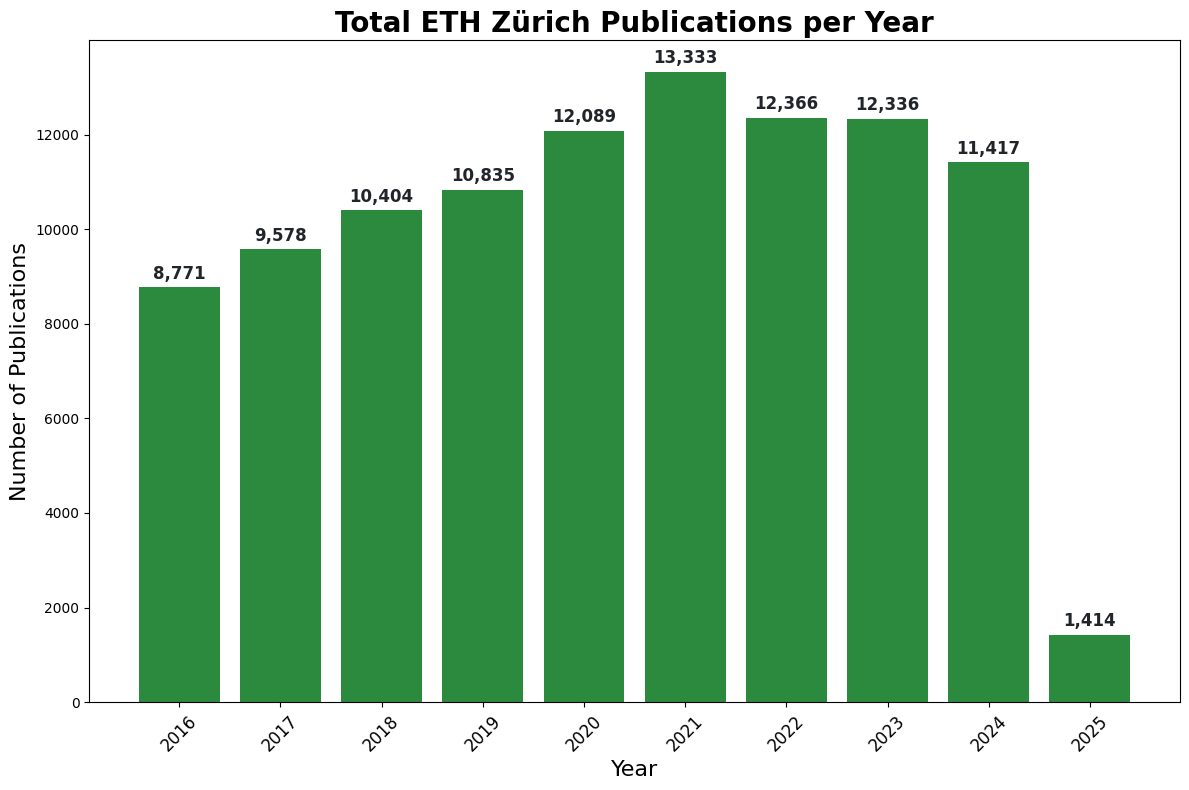

In [24]:
plot_bar_chart(df, f"Total ETH Zürich Publications per Year")

**Line chart**

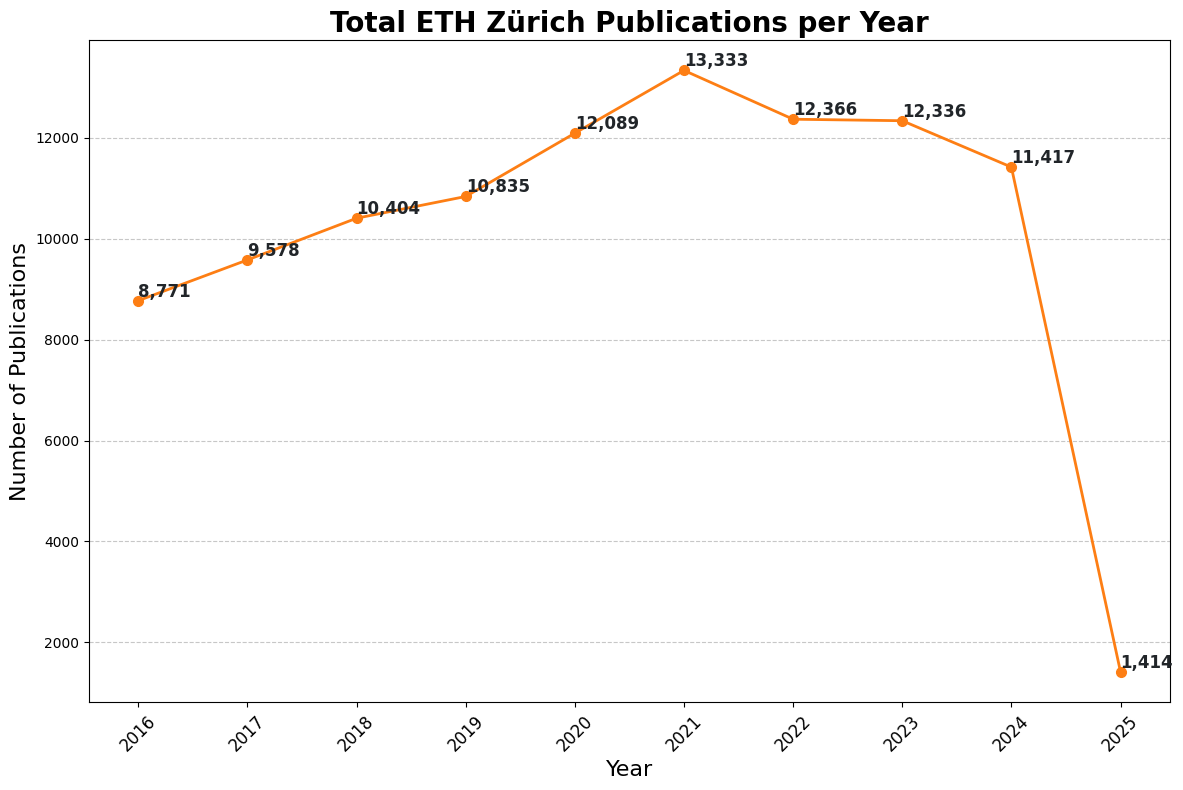

In [25]:
plot_line_chart(df, f"Total ETH Zürich Publications per Year")

##### (Optional) Step 1.11: Export to CSV

In [ ]:
#df.to_csv("publication_trends.csv", index=False)

### Analysis 2: Number of Articles per year for a selected institution
In this section, we focus on publications of type **article**. 

We will reuse the parameters and most functions from above.

##### Step 2.1 : Build Parameters
If you want to analyze another publication type, you can just modify `instanceType`.

Check [here](http://api.openaire.eu/vocabularies/dnet:publication_resource) for all possible instance type values.

In [27]:
def build_url_for_year(year, institution_id, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "fromPublicationDate": year,
        "toPublicationDate": year,
        "page": 1,        
        "pageSize": 100   
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}" # Encode the parameters
    return url

##### Step 2.2: Fetch Data for each year and create a DataFrame

In [28]:
all_data = [fetch_data_for_year(year, institution_id, base_url) for year in range(start_year, end_year + 1)]

df = pd.DataFrame(all_data)
df

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&fromPublicationDate=2016&toPublicationDate=2016&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&fromPublicationDate=2017&toPublicationDate=2017&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&fromPublicationDate=2018&toPublicationDate=2018&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&fromPublicationDate=2019&toPublicationDate=2019&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/re

,Year,Number of Publications
0,2016,7318
1,2017,7975
2,2018,8490
3,2019,8974
4,2020,10201
5,2021,11028
6,2022,9858
7,2023,10254
8,2024,9200
9,2025,1261


##### Step 2.3: Display Plots
**Bar Chart**

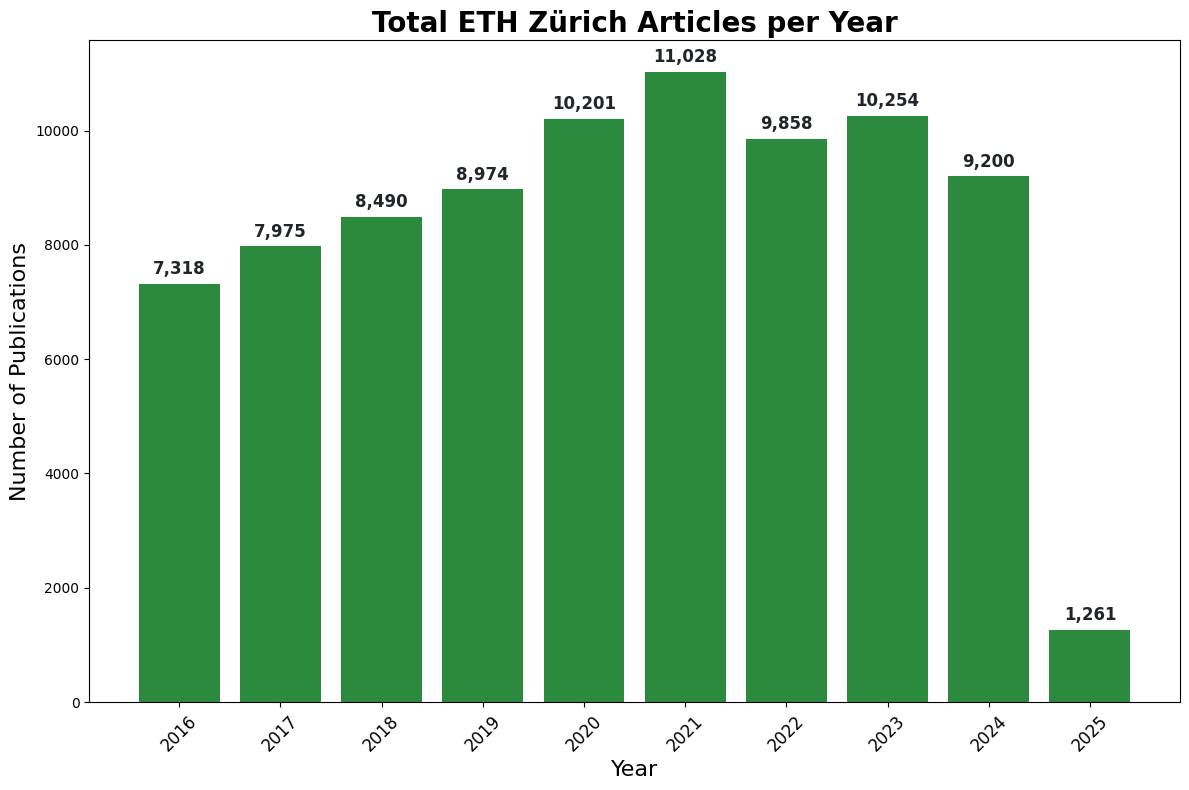

In [29]:
plot_bar_chart(df, "Total ETH Zürich Articles per Year")

**Line Chart**

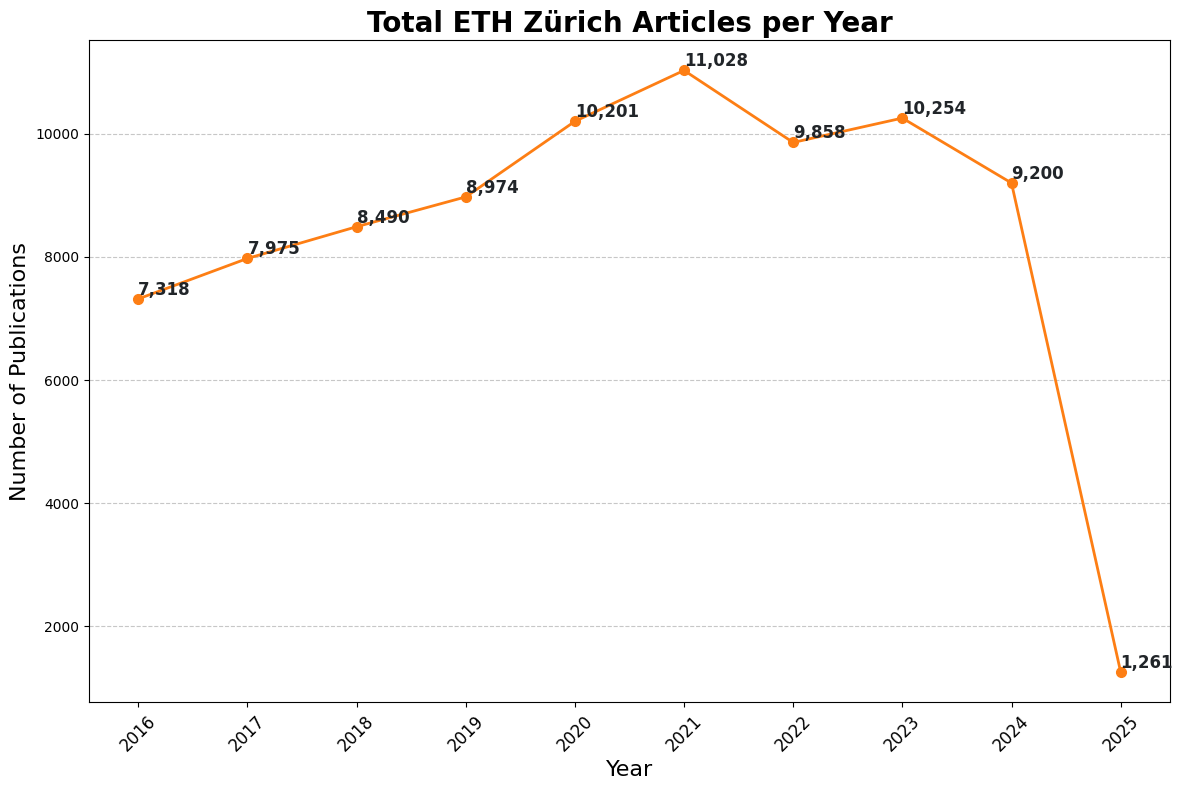

In [30]:
plot_line_chart(df, "Total ETH Zürich Articles per Year")

##### (Optional) Step 2.4: Export to CSV

In [ ]:
#df.to_csv("article_trends.csv", index=False)